In [1]:
import os
os.environ['OMP_NUM_THREADS']='4'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

from dolfin import *
from transient_adv import *

%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [2]:
# This script implements the skew-symmetric scheme mentioned in the following paper:
# Two-level schemes for the advection equation by Petr N. Vabishchevich.
# It consists of the theta family schemes and the R22 Pade schemes.

source = Constant(0.0)
init_cond = Expression('2e3*pow(x[0], 2)*pow(1.0-x[0], 4)*pow(x[1], 2)*pow(1.0-x[1], 4)', degree=1)

mesh_2d = RectangleMesh(Point(0,0), Point(1,1), 50, 50)
mesh_x = mesh_2d.coordinates()[:,0]
mesh_y = mesh_2d.coordinates()[:,1]
connectivity = mesh_2d.cells()

triang = Triangulation(mesh_x, mesh_y, connectivity)

CG_space = FunctionSpace(mesh_2d, 'CG', 1)
v_to_d = vertex_to_dof_map(CG_space)

In [3]:
%%time
dt_num = 0.005
end_time = 3.0
steps = int(end_time/dt_num)

# Explicit euler time stepping
u1 = transient_adv_2d_R11(mesh_2d, source, init_cond, dt_num=dt_num, steps=steps, theta_num=0.0)

CPU times: user 4.21 s, sys: 304 ms, total: 4.52 s
Wall time: 4.08 s


200


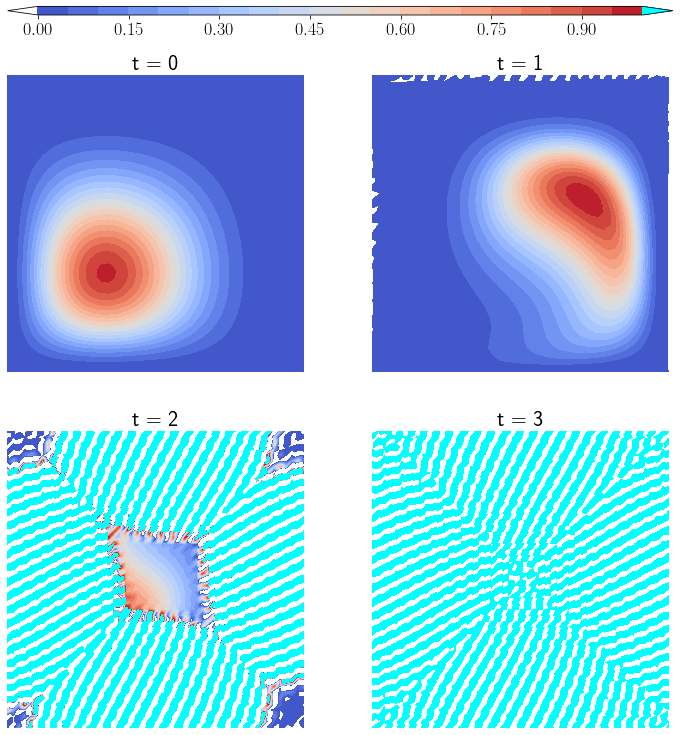

In [4]:
# The solution looks sharp in the beginning, but it eventually breaks down.
fig, ax = plt.subplots(2, 2, figsize=(12,12))

frame_index = int(1.0/dt_num)

print(frame_index)
for i, ax_elem in enumerate(ax.flatten()):
    cb = ax_elem.tricontourf(triang, u1[frame_index*i].vector()[v_to_d], cmap='coolwarm', levels=np.linspace(0, 1, 21), extend='both')
    cb.cmap.set_under('white')
    cb.cmap.set_over('cyan')
    ax_elem.set_aspect('equal')
    ax_elem.set_title('t = ' + str(i))

cbaxes = fig.add_axes([0.13, 0.95, 0.77, 0.01]) 
fig.colorbar(cb, cax=cbaxes, orientation='horizontal')

for ax_elem in ax.flatten():
    ax_elem.axis('off')
    
plt.show()

In [5]:
%%time
dt_num = 0.005
end_time = 3.0
steps = int(end_time/dt_num)

# Implicit euler time stepping
u1 = transient_adv_2d_R11(mesh_2d, source, init_cond, dt_num=dt_num, steps=steps, theta_num=1.0)

CPU times: user 3.64 s, sys: 51.8 ms, total: 3.69 s
Wall time: 3.69 s


200


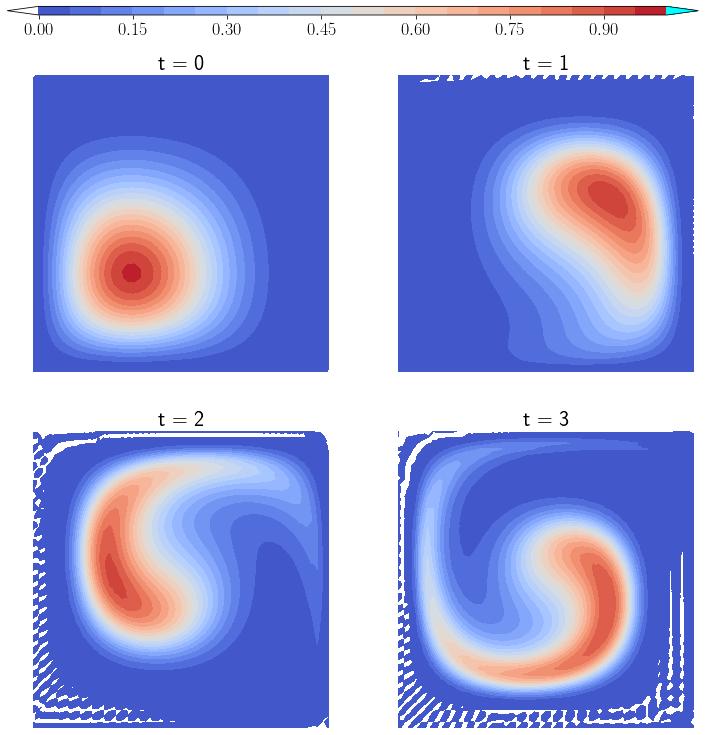

In [6]:
# The solution is overall stable, but it's diffusive.
# Notice the values between 0.95 and 1 disappeared after some timesteps.
fig, ax = plt.subplots(2, 2, figsize=(12,12))

frame_index = int(1.0/dt_num)

print(frame_index)
for i, ax_elem in enumerate(ax.flatten()):
    cb = ax_elem.tricontourf(triang, u1[frame_index*i].vector()[v_to_d], cmap='coolwarm', levels=np.linspace(0, 1, 21), extend='both')
    cb.cmap.set_under('white')
    cb.cmap.set_over('cyan')
    ax_elem.set_aspect('equal')
    ax_elem.set_title('t = ' + str(i))

cbaxes = fig.add_axes([0.1, 0.95, 0.8, 0.01]) 
fig.colorbar(cb, cax=cbaxes, orientation='horizontal')

for ax_elem in ax.flatten():
    ax_elem.axis('off')

plt.show()

In [7]:
%%time
dt_num = 0.005
end_time = 5.0
steps = int(end_time/dt_num)

# Crank-Nicolson time stepping
u1 = transient_adv_2d_R11(mesh_2d, source, init_cond, dt_num=dt_num, steps=steps, theta_num=0.5)

CPU times: user 6.53 s, sys: 88 ms, total: 6.62 s
Wall time: 6.62 s


200


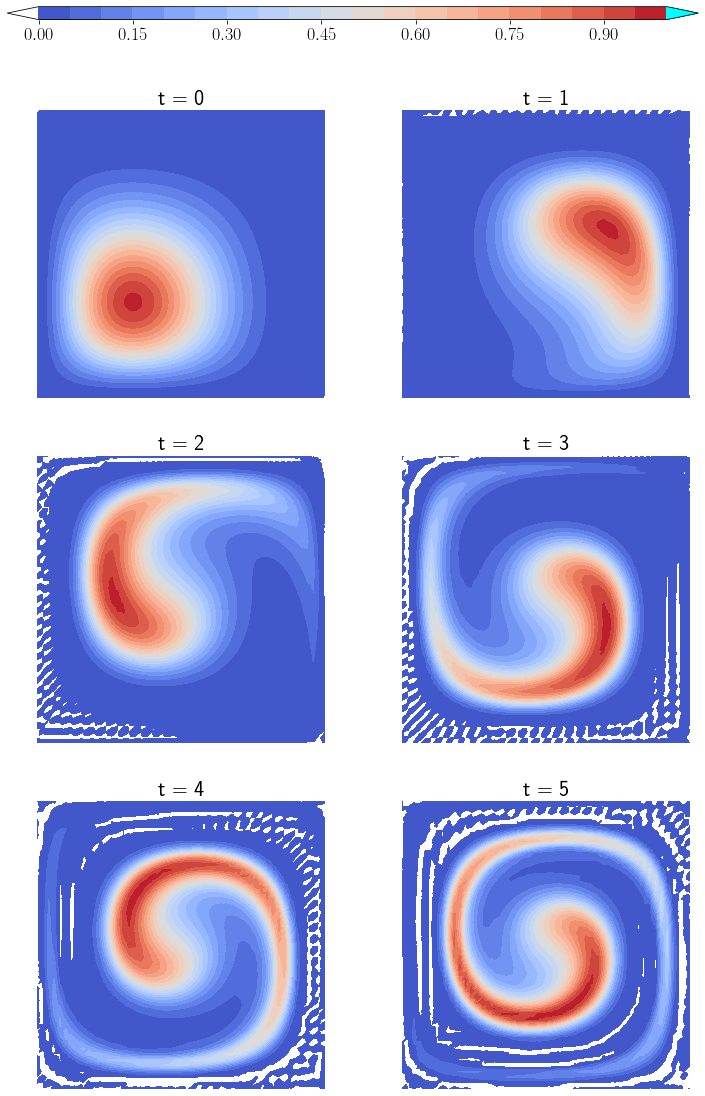

In [8]:
# The solution is stable, and it's not diffusive as the implicit Euler scheme.
fig, ax = plt.subplots(3, 2, figsize=(12,18))

frame_index = int(1.0/dt_num)

print(frame_index)
for i, ax_elem in enumerate(ax.flatten()):
    cb = ax_elem.tricontourf(triang, u1[frame_index*i].vector()[v_to_d], cmap='coolwarm', levels=np.linspace(0, 1, 21), extend='both')
    cb.cmap.set_under('white')
    cb.cmap.set_over('cyan')
    ax_elem.set_aspect('equal')
    ax_elem.set_title('t = ' + str(i))

cbaxes = fig.add_axes([0.1, 0.95, 0.8, 0.01]) 
fig.colorbar(cb, cax=cbaxes, orientation='horizontal')

for ax_elem in ax.flatten():
    ax_elem.axis('off')

plt.show()

In [3]:
%%time
dt_num = 0.08
end_time = 5.0
steps = int(end_time/dt_num)

# R22 time stepping
u1 = transient_adv_2d_R22(mesh_2d, source, init_cond, dt_num=dt_num, steps=steps)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
CPU times: user 1.7 s, sys: 52.3 ms, total: 1.75 s
Wall time: 2.71 s


12


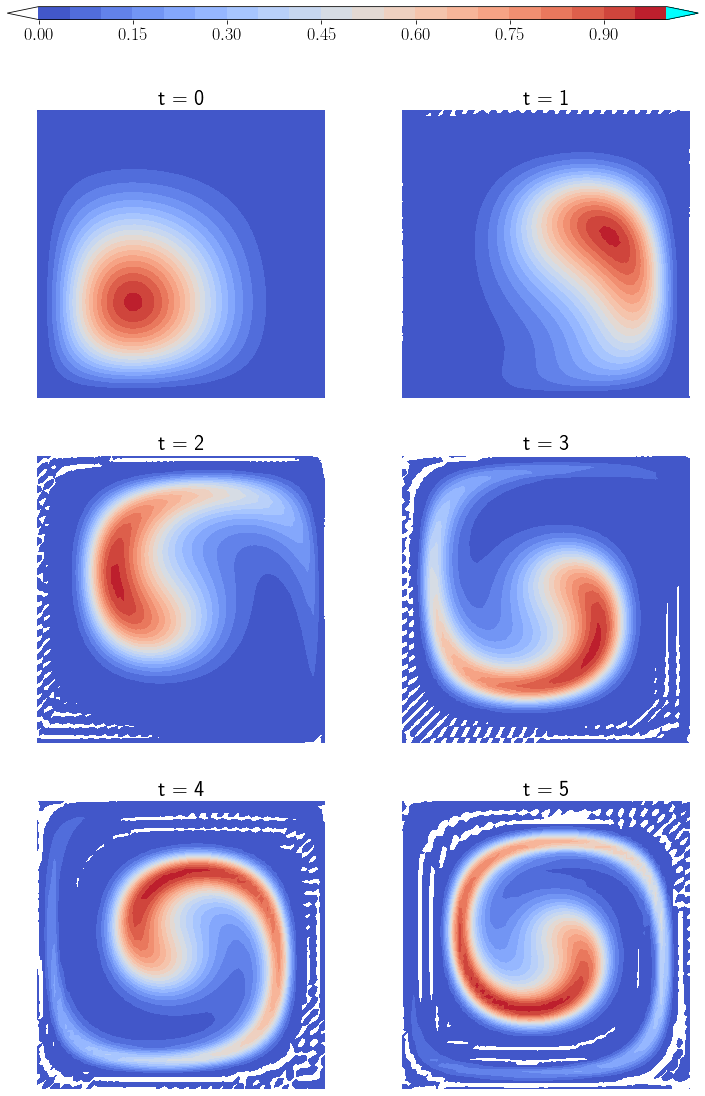

In [4]:
# The solution is stable, and requires less timesteps to reach a reasonable result.
# As a consequence, it requires double of the dofs to solve for each time step.

fig, ax = plt.subplots(3, 2, figsize=(12,18))

frame_index = int(1.0/dt_num)

print(frame_index)
for i, ax_elem in enumerate(ax.flatten()):
    cb = ax_elem.tricontourf(triang, u1[frame_index*i].vector()[v_to_d], cmap='coolwarm', levels=np.linspace(0, 1, 21), extend='both')
    cb.cmap.set_under('white')
    cb.cmap.set_over('cyan')
    ax_elem.set_aspect('equal')
    ax_elem.set_title('t = ' + str(i))

cbaxes = fig.add_axes([0.1, 0.95, 0.8, 0.01]) 
fig.colorbar(cb, cax=cbaxes, orientation='horizontal')

for ax_elem in ax.flatten():
    ax_elem.axis('off')

plt.show()

In [4]:
%%time
dt_num = 0.005
end_time = 3.0
steps = int(end_time/dt_num)
mesh_2d = RectangleMesh(Point(0,0), Point(1,1), 50, 50)

# Explicit euler time stepping
u1 = transient_adv_2d_upwind(mesh_2d, source, init_cond, dt_num=dt_num, steps=steps, theta_num=0.0, add_diff=0.0)

CPU times: user 7.01 s, sys: 344 ms, total: 7.35 s
Wall time: 6.94 s


200


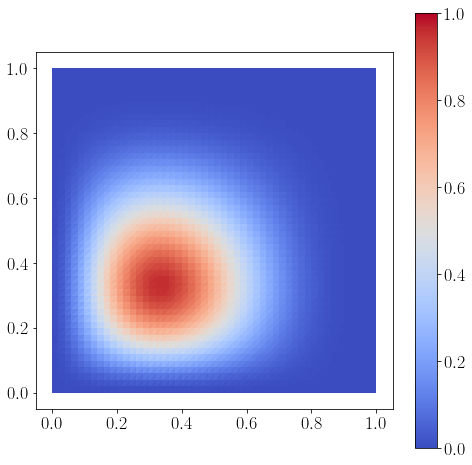

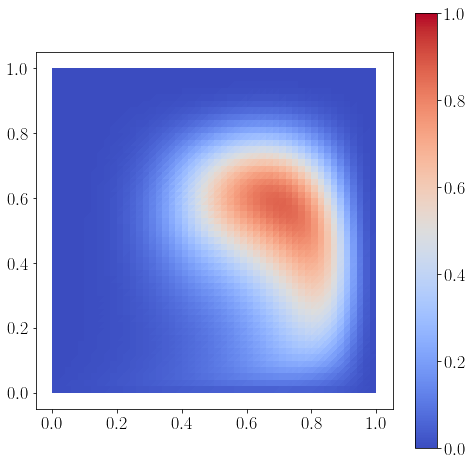

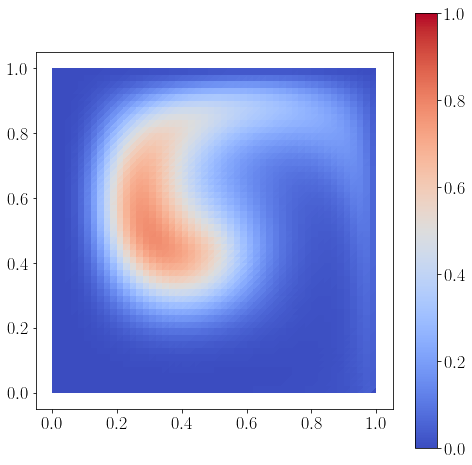

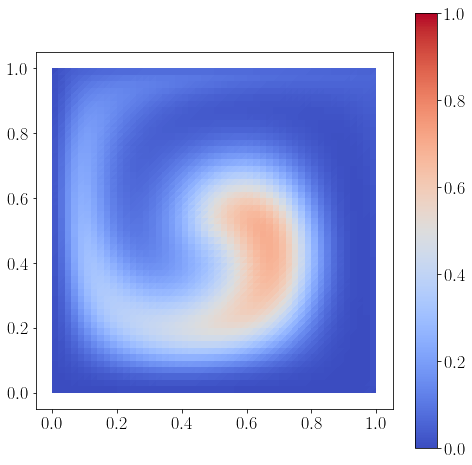

In [5]:
frame_index = int(1.0/dt_num)

print(frame_index)

for i in range(4):
    fig = plt.figure(figsize=(8,8))
    cb = plot(u1[frame_index*i], cmap='coolwarm', vmin=0.0, vmax=1.0)
    fig.colorbar(cb)

#cbaxes = fig.add_axes([0.13, 0.95, 0.77, 0.01]) 
#fig.colorbar(cb, cax=cbaxes, orientation='horizontal')

    
plt.show()

In [6]:
%%time
dt_num = 0.1
end_time = 5.0
steps = int(end_time/dt_num)
mesh_2d = RectangleMesh(Point(0,0), Point(1,1), 100, 100)

u1 = transient_adv_2d_R22_FV(mesh_2d, source, init_cond, dt_num=dt_num, steps=steps)

CPU times: user 14.8 s, sys: 16.1 s, total: 30.9 s
Wall time: 7.89 s


10


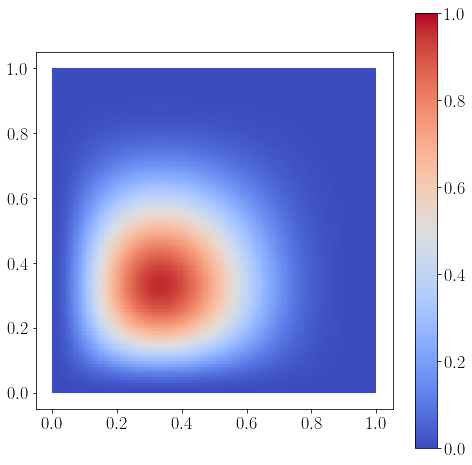

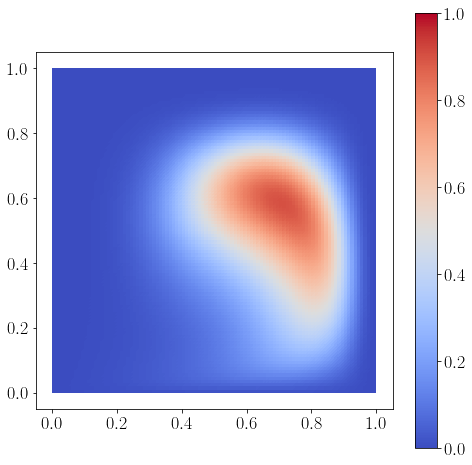

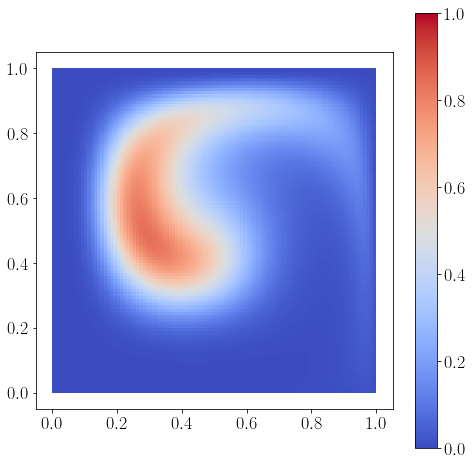

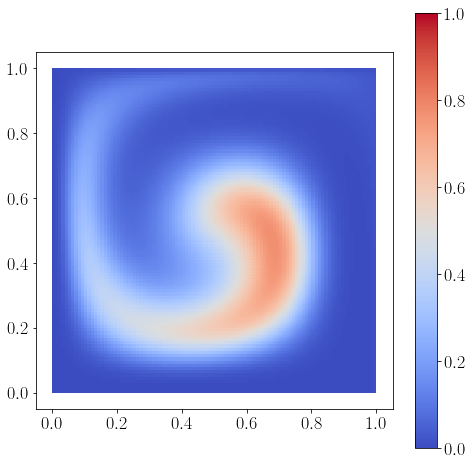

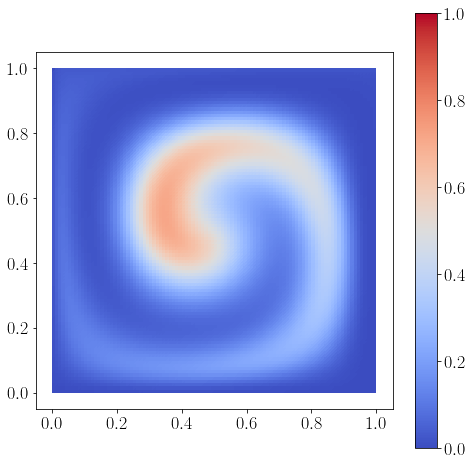

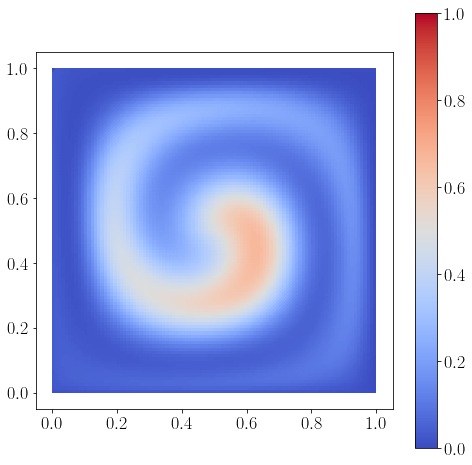

In [7]:
frame_index = int(1.0/dt_num)

print(frame_index)

for i in range(6):
    fig = plt.figure(figsize=(8,8))
    cb = plot(u1[frame_index*i], cmap='coolwarm', vmin=0.0, vmax=1.0)
    fig.colorbar(cb)

#cbaxes = fig.add_axes([0.13, 0.95, 0.77, 0.01]) 
#fig.colorbar(cb, cax=cbaxes, orientation='horizontal')

    
plt.show()